In [22]:
import torch
import tomosipo as ts
import numpy as np
from ts_algorithms import fbp, sirt, tv_min2d, fdk, nag_ls
import matplotlib.pyplot as plt

print(torch.__version__)

2.0.1


In [25]:
dev = torch.device("cpu")
dev

device(type='cpu')

In [31]:
sino_slice = torch.from_numpy(np.load('sino_from_reconstructed_slice.npy')).to(dev).reshape(1,900,3916)
sino_shape = sino_slice.shape
print(sino_shape)

torch.Size([1, 900, 3916])


In [33]:
# Setup up volume and parallel projection geometry
vg = ts.volume(shape=(1, 3916, 3916))
pg = ts.parallel(angles=900, shape=(1, 3916))
A = ts.operator(vg, pg)

# reconstructions made with different algorithms
rec_fbp = fbp(A, sino_slice)
rec_sirt = sirt(A, sino_slice, num_iterations=100)
rec_tv_min = tv_min2d(A, sino_slice, 0.0001, num_iterations=100)
rec_nag_ls = nag_ls(A, sino_slice, num_iterations=100)

c:\Users\bherr\miniconda3\envs\tomosipo\lib\site-packages\tomosipo\links\torch.py:55: UserWarning: The parameter initial_value is of type torch.float64; expected `torch.float32`. The type has been automatically converted. Use `ts.link(x.to(dtype=torch.float32))' to inhibit this warning. 
  warnings.warn(


KeyboardInterrupt: 

In [17]:
# # Setup up volume and parallel projection geometry
# vg = ts.volume(shape=(1, 256, 256))
# pg = ts.parallel(angles=384, shape=(1, 384))
# A = ts.operator(vg, pg)

# # Create hollow cube phantom
# x = torch.zeros(A.domain_shape)
# x[:, 10:-10, 10:-10] = 1.0
# x[:, 20:-20, 20:-20] = 0.0

# # Forward project
# y = A(x)

# # reconstructions made with different algorithms
# rec_fbp = fbp(A, y)
# rec_sirt = sirt(A, y, num_iterations=100)
# rec_tv_min = tv_min2d(A, y, 0.0001, num_iterations=100)
# rec_nag_ls = nag_ls(A, y, num_iterations=100)

KeyboardInterrupt: 

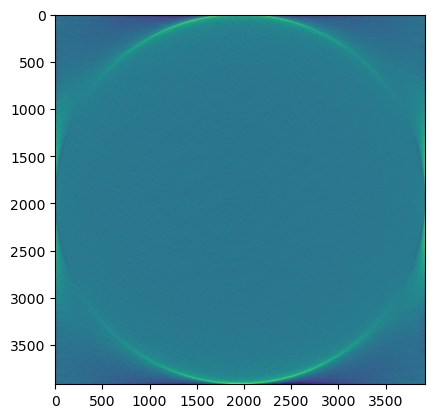

In [35]:
plt.imshow(rec_sirt.squeeze())